# LSTM vs SVM

Juan Navarro, <jsnavarroa@unal.edu.co>

-------------------------------


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [3]:
data_path = os.path.abspath("./data")

In [7]:
import pandas as pd

report = pd.read_csv(data_path+"/report.csv")

## 4. Time series to supervised problem

In [9]:
from sklearn import preprocessing

# https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
		data: Sequence of observations as a DataFrame.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
    n_vars = data.size
    df = data
    cols = pd.DataFrame()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        name = 'var(t-{})'.format(i)
        cols[name] = df.shift(i)
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        
        if i == 0:
            name = 'var(t)'
        else:
            name = 'var(t+{})'.format(i)
            
        cols[name] = df.shift(-i)
    
    # drop rows with NaN values
    if dropnan:
        cols.dropna(inplace=True)
    return cols

data = pd.DataFrame()

    
data['t'] = report['Rentab. dia']

data['t+1'] = data['t'].shift(-1)
    

data = series_to_supervised(report['Rentab. dia'], 1)

data.head()

# Make stationary, N=1, sequence size
data = data['var(t)'] - data['var(t-1)']

# Scale for LSTM
x = data.values.reshape(-1, 1)
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaled_X = scaler.fit_transform(x)

data = pd.Series(scaled_X[:, 0])

(506,)
(507,)


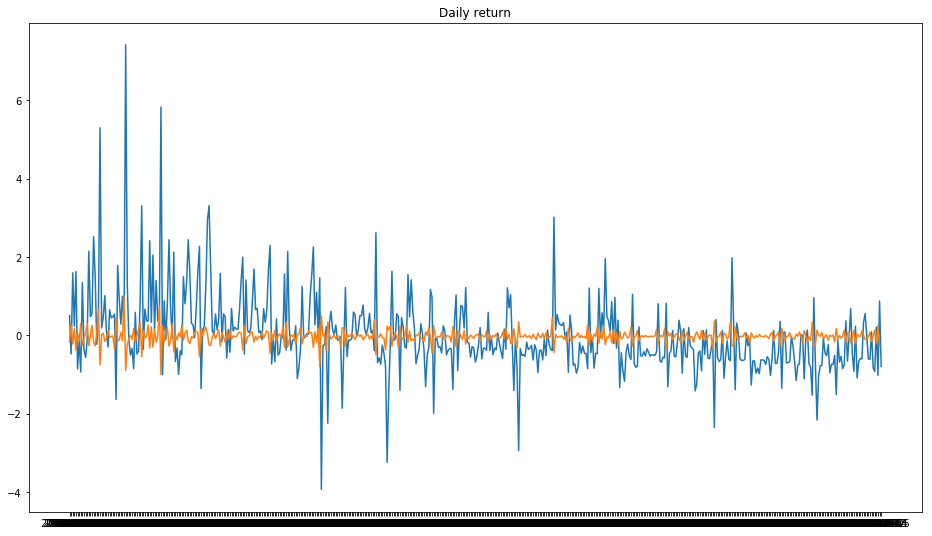

In [10]:
print(data.shape)
print(report['Fecha corte'].shape)

fig, ax1 = plt.subplots(1, 1, figsize=(16, 9))
ax1.plot(report['Fecha corte'], report['Rentab. dia'])
ax1.plot(report['Fecha corte'].iloc[:data.shape[0]], data)
ax1.set_title('Daily return')
plt.show()

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# fit the model
lstm_model = fit_lstm(data.values, 1, 3000, 4)

/home/juan/Programas/Miniconda3/envs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


IndexError: too many indices for array